In [1]:
import pandas as pd
import numpy as np
import pickle
import os

from scipy.stats import kurtosis, skew
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.models import load_model
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz


Using TensorFlow backend.


In [2]:
LABELS = [
    "HAZMEI'S SEXY POSE (NEUTRAL)", 
    "HAZMEI'S FLYING KISS (WAVE HANDS)",
    "HYUN'S MAD DRIVING SKILLS (BUS DRIVING)",
    "ENCIK'S IPPT 2.4KM (FRONT BACK)",
    "HYUN'S BALLET DANCE (SIDE STEP)",
    "HAZMEI'S BELLY BOUNCE (JUMPING)",
    "JUMPING JACK",
    "TURN CLAP",
    "SQUAT TURN CLAP",
    "WINDOW",
    "WINDOW 360",
    "MONEY (FINAL MOVE)"
]

'''LABELS = [
    "HAZMEI'S SEXY POSE (NEUTRAL)", 
    "HAZMEI'S FLYING KISS (WAVE HANDS)",
    "HYUN'S MAD DRIVING SKILLS (BUS DRIVING)",
    "ENCIK'S IPPT 2.4KM (FRONT BACK)",
    "HYUN'S BALLET DANCE (SIDE STEP)",
    "HAZMEI'S BELLY BOUNCE (JUMPING)"
] '''

SAMPLING_RATE = 50
WINDOW_SIZE = 2.4
WINDOW_READINGS = int(WINDOW_SIZE * SAMPLING_RATE)
DATAPATH = 'data_all/'

ORDER = 3       # Order 3
CUTOFF = 7    # desired cutoff frequency of the filter in Hz (take max/60)
FILTER_SAMPLING_RATE = 20

In [3]:
def normalize_data(data):
    data_norm = (data - data.mean()) / (data.max() - data.min())
    return np.array(data_norm)

def frequency(data):
    fourier = np.fft.fft(data)
    freqs = np.fft.fftfreq(len(data), d=1/SAMPLING_RATE)
    
def magnitude(x, y, z):
    x_sq = np.power(x, 2)
    y_sq = np.power(y, 2)
    z_sq = np.power(z, 2)

    xyz_sq = x_sq + y_sq + z_sq

    xyz_mag = np.sqrt(xyz_sq)
    return xyz_mag

def rms(x, axis=None):
    return np.sqrt(np.mean(np.power(x, 2), axis=axis))

def feature_extraction(x, y, z):
    #'''
    #mean, std
    features = [np.mean(x), np.mean(y), np.mean(z), np.std(x), np.std(y), np.std(z)]
    #Median Absolute Deviation
    features.extend((np.mean(abs(x - features[0])), np.mean(abs(y - features[1])), np.mean(abs(z - features[2]))))
    #Jerk Signals mean, std, mad
    features.extend((np.mean(np.diff(x)), np.mean(np.diff(y)), np.mean(np.diff(z)), np.std(np.diff(x)), np.std(np.diff(y)), np.std(np.diff(z))))
    features.extend((np.mean(abs(np.diff(x) - features[9])), np.mean(abs(np.diff(y) - features[10])), np.mean(abs(np.diff(y) - features[11]))))
    #max, min
    features.extend((max(x), max(y), max(z), min(x), min(y), min(z)))
    #correlation
    features.extend((np.correlate(x, y)[0], np.correlate(x, z)[0], np.correlate(y, z)[0]))
    #energy
    features.extend((np.dot(x,x)/len(x), np.dot(y,y)/len(y), np.dot(z,z)/len(z)))
    #iqr
    #features.extend((np.subtract(*np.percentile(x, [75, 25])), np.subtract(*np.percentile(y, [75, 25])), np.subtract(*np.percentile(z, [75, 25]))))
    #Root Mean Square
    features.extend((rms(x), rms(y), rms(z)))
    #Skew, Kurtosis
    features.extend((skew(x), skew(y), skew(z), kurtosis(x), kurtosis(y), kurtosis(z)))
    #'''
    
    '''
    #Frequency Domain Features
    fourier_x = np.fft.fft(x)
    fourier_y = np.fft.fft(x)
    fourier_z = np.fft.fft(x)
    freqs = np.fft.fftfreq(WINDOW_READINGS)
    fourier_x = np.abs(fourier_x)
    fourier_y = np.abs(fourier_y)
    fourier_z = np.abs(fourier_z)
    #Mean Frequency, Skew, Kurtosis
    features.extend((np.mean(fourier_x), np.mean(fourier_y), np.mean(fourier_z)))
    features.extend((skew(fourier_x), skew(fourier_y), skew(fourier_z), kurtosis(fourier_x), kurtosis(fourier_y), kurtosis(fourier_z)))
    '''

    '''
    #Old Feature Extraction
    features = [np.mean(x), np.mean(y), np.mean(z), np.std(x), np.std(y), np.std(z)]
    #Median Absolute Deviation
    features.extend((np.mean(abs(x - features[0])), np.mean(abs(y - features[1])), np.mean(abs(z - features[2]))))
    #Jerk Signals
    features.extend((np.mean(np.diff(x)), np.mean(np.diff(y)), np.mean(np.diff(z)), np.std(np.diff(x)), np.std(np.diff(y)), np.std(np.diff(z))))
    features.extend((np.mean(abs(np.diff(x) - features[9])), np.mean(abs(np.diff(y) - features[10])), np.mean(abs(np.diff(y) - features[11]))))
    features.extend((skew(x), skew(y), skew(z), kurtosis(x), kurtosis(y), kurtosis(z)))
    features.extend((max(x), max(y), max(z), min(x), min(y), min(z)))
    '''
    
    return features

def add_noise(data):
    data_noise = data + np.random.uniform(size=len(data))
    data_noise = data_noise + np.random.laplace(loc=0.0, scale=1.0, size=len(data))
    return data_noise

def data_augmentation(X):
    X_noise = X
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            X_noise[i][:][j] = add_noise(X_noise[i][:][j])
    return np.concatenate((X, X_noise), axis=0)

def feature_selection(X, augmentData=False):
    data = []
    for i in range(X.shape[0]):
        features = []
        for j in range(0, X.shape[2], 3):
            x = [X[i][u][j] for u in range(X.shape[1])]
            y = [X[i][u][j+1] for u in range(X.shape[1])]
            z = [X[i][u][j+2] for u in range(X.shape[1])]
            
            if augmentData:
                x_noise = add_noise(x)
                y_noise = add_noise(y)
                z_noise = add_noise(z)
                features.append(feature_extraction(x_noise, y_noise, z_noise))
            else:
                features.append(feature_extraction(x, y, z))

        data.append(features)
    return np.array(data)

def feature_engineering(X, augmentData=False):
    if augmentData:
        return np.concatenate((feature_selection(X, False), feature_selection(X, True)), axis=0)
    else:
        return feature_selection(X, False)
    
def shitHotLP(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order)
    v = butter_lowpass_filter(data, cutoff, fs, order)
    return v

def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


def read_data(filename, label):
    raw_data = pd.read_csv(filename)
    raw_data = raw_data.iloc[100:-50, 0:9]
    raw_data = raw_data[:raw_data.shape[0]-(raw_data.shape[0]%WINDOW_READINGS)]
    #print(raw_data.shape)
    #print(filename, ': Minimum: ', np.min(raw_data))
    #print(filename, ': Maximum: ', np.max(raw_data))

    
    normalized_data = shitHotLP(raw_data, CUTOFF, FILTER_SAMPLING_RATE, ORDER)
    sampled_data = normalized_data.reshape(-1, WINDOW_READINGS, 9)
    #print(sampled_data.shape)
    return sampled_data, [label]*sampled_data.shape[0] 



def import_data(root_dirpath, test_data_size, test_data_filename):
    X = np.zeros([1,WINDOW_READINGS,9])
    Xt = np.zeros([1,WINDOW_READINGS,9])
    y = []
    yt = []
    
    sub_directories = next(os.walk(root_dirpath))[1] 
    sub_directories.sort()
    #print(sub_directories)
    for sub_dir in sub_directories:
        files = next(os.walk(root_dirpath + sub_dir))[2]
        #print(sub_dir, " ", files)
        count = 0
        samples = 0
        for file in files:
            if not file or file == '.DS_Store':
                continue
            #print(file)
            temp_x, temp_y = read_data(root_dirpath + sub_dir + '/' + file, int(sub_dir))
            if count < test_data_size and test_data_filename in file:
            #if test_data_filename in file:
                print(file, ' size: ', len(temp_y))
                Xt = np.concatenate((Xt, temp_x), axis=0)
                yt = yt + temp_y
            else:
                X = np.concatenate((X, temp_x), axis=0)
                y = y + temp_y
            count = count + 1 if len(temp_y) > 40 else count + 0.5
            samples += len(temp_y)
            
        print(LABELS[y[-1]], ': ', samples)
    y = np.array(y)
    yt = np.array(yt)
    return X[1:], y, Xt[1:], yt


In [4]:
X, Y, Xt, Yt = import_data(DATAPATH, 1, "")
print(X.shape)
print(Y.shape)
print(Xt.shape)
print(Yt.shape)

#print(X)
#print(Y)
print(Yt)

santos_natural.csv  size:  52
HAZMEI'S SEXY POSE (NEUTRAL) :  426
rahman_waving.csv  size:  52
HAZMEI'S FLYING KISS (WAVE HANDS) :  416
santos_window360_2.csv  size:  25
hazmei_window360_1.csv  size:  25
WINDOW 360 :  424
hazmei_logout.csv  size:  25
santos_final_2.csv  size:  25
MONEY (FINAL MOVE) :  204
121017_hazmei_busdriver.csv  size:  51
HYUN'S MAD DRIVING SKILLS (BUS DRIVING) :  419
rahman_frontback.csv  size:  52
ENCIK'S IPPT 2.4KM (FRONT BACK) :  413
hyun_sidestep.csv  size:  52
HYUN'S BALLET DANCE (SIDE STEP) :  413
yz_jumping.csv  size:  52
HAZMEI'S BELLY BOUNCE (JUMPING) :  277
hyun_jumpingjack.csv  size:  51
JUMPING JACK :  226
hazmei_turnclap2.csv  size:  25
hazmei_turnclap1.csv  size:  25
TURN CLAP :  225
hyun_squatturnclap_1.csv  size:  25
hazmei_squatturnclap.csv  size:  25
SQUAT TURN CLAP :  292
hazmei_window_3.csv  size:  25
hazmei_window_2.csv  size:  25
WINDOW :  508
(3631, 120, 9)
(3631,)
(612, 120, 9)
(612,)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [5]:
#Raw Data with Data Augmentation
'''
X = data_augmentation(X)
Xt = data_augmentation(Xt)
Y = np.concatenate((Y, Y), axis=0)
Yt = np.concatenate((Yt, Yt), axis=0)
'''

#Feature Selection & Data Augmentation

#X = feature_engineering(X, False)
#Xt = feature_engineering(Xt, False)
#Y = np.concatenate((Y, Y), axis=0)
#Yt = np.concatenate((Yt, Yt), axis=0)





Yhot = to_categorical(Y)

print(X.shape)
print(Xt.shape)
print(Yhot.shape)
#print([Xt[i] for i in Sample])

np.savetxt("data/test_data_format.csv", Xt[0], delimiter=",")

#X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
#Xt = Xt.reshape(Xt.shape[0], Xt.shape[1]*Xt.shape[2])


(3631, 120, 9)
(612, 120, 9)
(3631, 12)


0


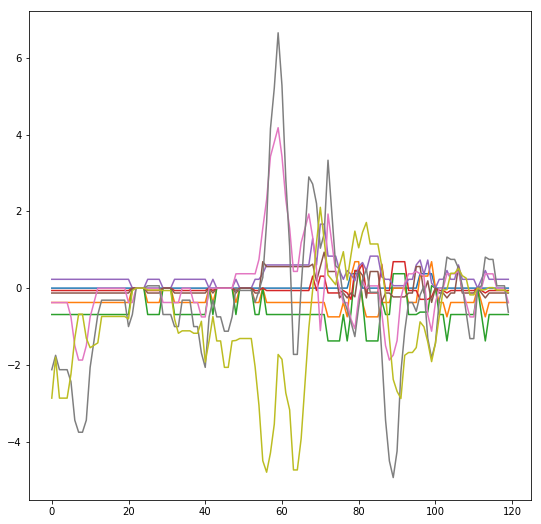

(9, 120)
1.24322557523


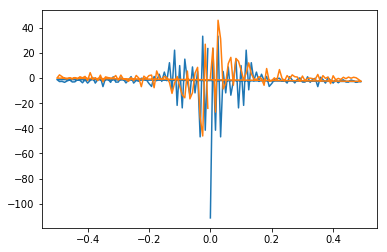

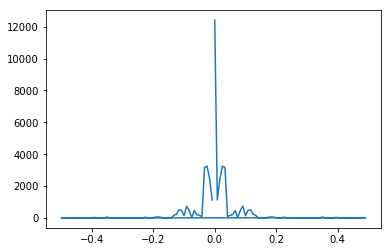

/Users/arshanrahman/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


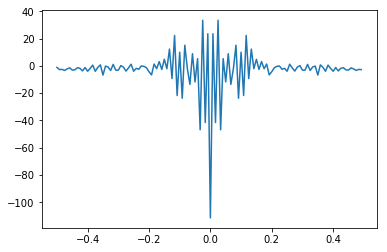

0.491666666667
341.489858596
0


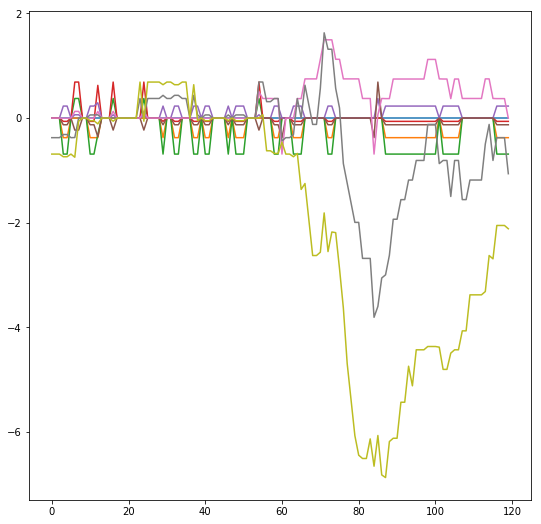

(9, 120)
0.0


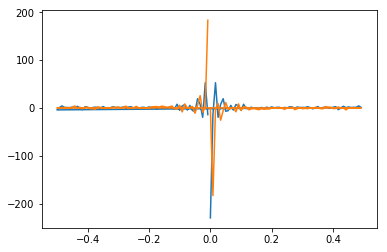

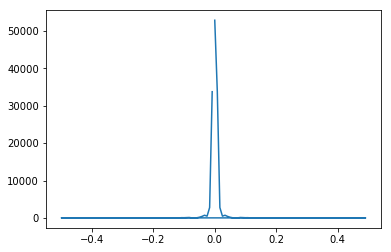

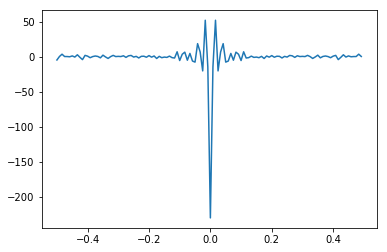

0.491666666667
1090.4608953


In [6]:
#Plot Data
Size = Xt.shape[1];
Sample = [35, 40]
legends = ['acc1x', 'acc1y', 'acc1z', 'acc1x', 'acc2y', 'acc3z', 'gyrox', 'gyroy', 'gyroz']

for i in Sample:
    print(Yt[i])
    plt.figure(figsize=(9,9))
    plt.plot(list(range(Size)), Xt[i][:][:], label=legends )
    plt.show()

    temp = Xt[i][:][:].T
    print(temp.shape)
    #print(temp[0])
    print(np.correlate(temp[0], temp[1])[0])

    fourier = np.fft.fft(temp[8])
    freqs = np.fft.fftfreq(temp.shape[1])
    plt.plot(freqs, fourier.real, freqs, fourier.imag)
    plt.show()

    plt.plot(freqs, np.abs(fourier)**2)
    plt.show()

    idx = np.argsort(freqs)
    plt.plot(freqs[idx], fourier[idx])
    plt.show()
    print(max(freqs))
    print(np.mean(np.abs(fourier)**2))



#print(fourier)
#print(freqs)
#print(np.abs(fourier))
#print(np.mean(fourier))
#print(freqs)
#print(np.abs(freqs[0:51]))

In [7]:
#Prediction

def predict(model):
    Y_output = model.predict(Xt)
    Y_pred = np.argmax(Y_output, axis=1)
    print(np.array(Y_pred))
    print("")
    print("Accuracy Rate:")
    print(metrics.accuracy_score(Yt, Y_pred))
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(Yt, Y_pred)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100
    
    '''
    print("Precision: {}%".format(100*metrics.precision_score(Yt, Y_pred, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(Yt, Y_pred, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(Yt, Y_pred, average="weighted")))
    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    '''
    
    # Plot Results: 
    plt.figure(figsize=(12, 12))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(len(LABELS))
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    np.savetxt(DATAPATH+"accuracy.csv", [metrics.accuracy_score(Yt, Y_pred)], delimiter=",")
    np.savetxt(DATAPATH+"confusion_matrix.csv", metrics.confusion_matrix(Yt, Y_pred), delimiter=",")
    model.save(DATAPATH+'trained_cnn_model.h5')

Train on 3267 samples, validate on 364 samples
Epoch 1/50
3267/3267 [==============================] - 6s - loss: 1.4093 - acc: 0.5803 - val_loss: 0.5880 - val_acc: 0.8049
Epoch 2/50
3267/3267 [==============================] - 4s - loss: 0.6409 - acc: 0.7854 - val_loss: 0.2623 - val_acc: 0.9148
Epoch 3/50
3267/3267 [==============================] - 4s - loss: 0.4471 - acc: 0.8393 - val_loss: 0.3249 - val_acc: 0.8654
Epoch 4/50
3267/3267 [==============================] - 4s - loss: 0.3753 - acc: 0.8662 - val_loss: 0.5152 - val_acc: 0.8571
Epoch 5/50
3267/3267 [==============================] - 4s - loss: 0.3201 - acc: 0.8889 - val_loss: 1.0968 - val_acc: 0.7665
Epoch 6/50
3267/3267 [==============================] - 4s - loss: 0.3215 - acc: 0.8947 - val_loss: 0.9473 - val_acc: 0.8187
Epoch 7/50
3267/3267 [==============================] - 4s - loss: 0.2875 - acc: 0.9005 - val_loss: 0.4192 - val_acc: 0.8819
Epoch 8/50
3267/3267 [==============================] - 4s - loss: 0.2187 - ac

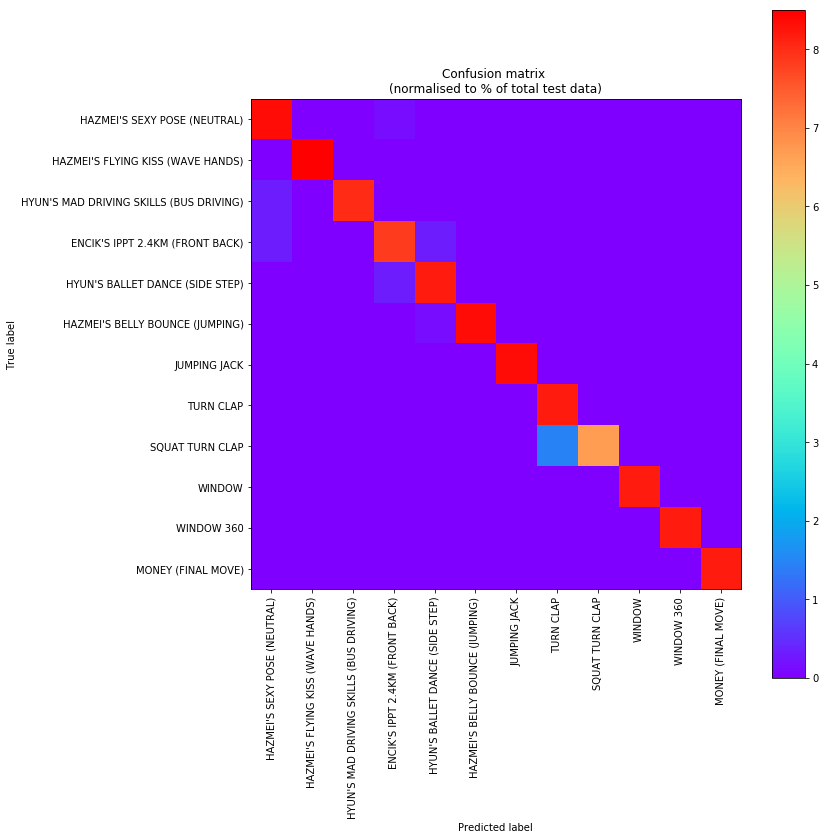

In [38]:
#Neural Network

data_dim = X.shape[2]
timesteps = X.shape[1]
num_classes = Yhot.shape[1]
b_size = 32

model = Sequential()
model.add(Dense(70, input_shape=(timesteps, data_dim)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

'''model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))'''

model.add(Dense(70))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Yhot, epochs=50, batch_size=b_size, validation_split=0.1, shuffle=True)
result = model.evaluate(X, Yhot)
print("\n%s: %.2f%%" % (model.metrics_names[0], result[0]))
print("\n%s: %.2f%%" % (model.metrics_names[1], result[1]*100))

predict(model)

Train on 3267 samples, validate on 364 samples
Epoch 1/80
3267/3267 [==============================] - 3s - loss: 2.0054 - acc: 0.3330 - val_loss: 2.9421 - val_acc: 0.0000e+00
Epoch 2/80
3267/3267 [==============================] - 2s - loss: 1.4570 - acc: 0.5314 - val_loss: 2.6239 - val_acc: 0.0000e+00
Epoch 3/80
3267/3267 [==============================] - 2s - loss: 1.2027 - acc: 0.5917 - val_loss: 2.1542 - val_acc: 0.0000e+00
Epoch 4/80
3267/3267 [==============================] - 2s - loss: 1.0137 - acc: 0.6413 - val_loss: 1.6253 - val_acc: 0.1484
Epoch 5/80
3267/3267 [==============================] - 2s - loss: 0.8946 - acc: 0.6832 - val_loss: 1.2984 - val_acc: 0.5137
Epoch 6/80
3267/3267 [==============================] - 1s - loss: 0.7872 - acc: 0.7270 - val_loss: 1.2416 - val_acc: 0.5440
Epoch 7/80
3267/3267 [==============================] - 2s - loss: 0.7449 - acc: 0.7426 - val_loss: 0.9744 - val_acc: 0.6841
Epoch 8/80
3267/3267 [==============================] - 2s - loss:

3267/3267 [==============================] - 1s - loss: 0.2793 - acc: 0.9017 - val_loss: 0.8017 - val_acc: 0.7775
Epoch 66/80
3267/3267 [==============================] - 2s - loss: 0.2954 - acc: 0.8968 - val_loss: 0.5696 - val_acc: 0.8104
Epoch 67/80
3267/3267 [==============================] - 2s - loss: 0.2773 - acc: 0.9011 - val_loss: 0.7629 - val_acc: 0.7912
Epoch 68/80
3267/3267 [==============================] - 1s - loss: 0.2837 - acc: 0.9027 - val_loss: 0.6636 - val_acc: 0.8049
Epoch 69/80
3267/3267 [==============================] - 1s - loss: 0.2645 - acc: 0.9085 - val_loss: 0.7241 - val_acc: 0.8077
Epoch 70/80
3267/3267 [==============================] - 1s - loss: 0.2749 - acc: 0.9060 - val_loss: 0.5372 - val_acc: 0.8214
Epoch 71/80
3267/3267 [==============================] - 1s - loss: 0.2992 - acc: 0.8938 - val_loss: 0.6736 - val_acc: 0.7967
Epoch 72/80
3267/3267 [==============================] - 1s - loss: 0.2858 - acc: 0.8975 - val_loss: 0.6307 - val_acc: 0.8049
Epoc

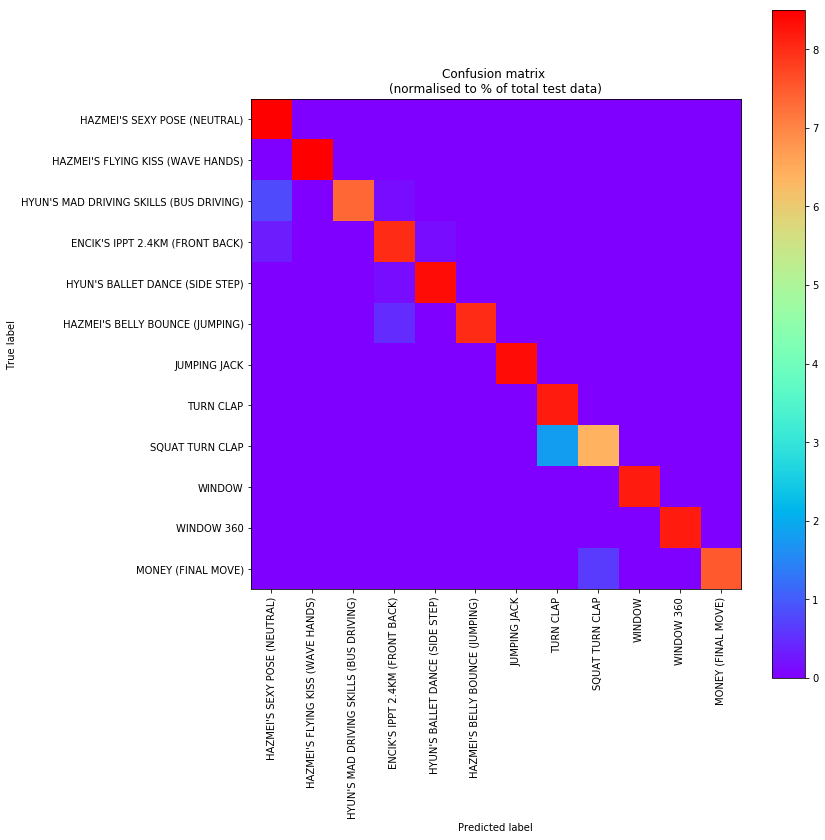

In [34]:
#CNN Neural Network

data_dim = X.shape[2]
timesteps = X.shape[1]
num_classes = Yhot.shape[1]
b_size = 32

model = Sequential()
model.add(Conv1D(64, 2, padding='valid', strides=2, input_shape=(timesteps, data_dim)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.4))

model.add(Conv1D(64, 2, padding='valid', strides=2) )
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.4))

model.add(Conv1D(32, 1, padding='valid', strides=2) )
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Activation('relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Yhot, epochs=80, batch_size=b_size, validation_split=0.1, shuffle=True)
result = model.evaluate(X, Yhot)
print("\n%s: %.2f%%" % (model.metrics_names[0], result[0]))
print("\n%s: %.2f%%" % (model.metrics_names[1], result[1]*100))

predict(model)

In [10]:
#LSTM Neural Network

'''data_dim = X.shape[2]
timesteps = X.shape[1]
num_classes = Yhot.shape[1]
b_size = 32

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(timesteps, data_dim)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Yhot, epochs=5, batch_size=b_size, validation_split=0.1, shuffle=True)
result = model.evaluate(X, Yhot)
print("\n%s: %.2f%%" % (model.metrics_names[0], result[0]))
print("\n%s: %.2f%%" % (model.metrics_names[1], result[1]*100))

predict(model)'''

'data_dim = X.shape[2]\ntimesteps = X.shape[1]\nnum_classes = Yhot.shape[1]\nb_size = 32\n\nmodel = Sequential()\nmodel.add(LSTM(64, return_sequences=True, input_shape=(timesteps, data_dim)))\nmodel.add(BatchNormalization())\nmodel.add(Activation(\'relu\'))\nmodel.add(Dropout(0.2))\n\nmodel.add(LSTM(64, return_sequences=True))\nmodel.add(BatchNormalization())\nmodel.add(Activation(\'relu\'))\nmodel.add(Dropout(0.2))\n\nmodel.add(LSTM(64, return_sequences=True))\nmodel.add(BatchNormalization())\nmodel.add(Activation(\'relu\'))\nmodel.add(Flatten())\nmodel.add(Dense(num_classes, activation=\'softmax\'))\n\nmodel.compile(loss=\'categorical_crossentropy\',\n              optimizer=\'adam\',\n              metrics=[\'accuracy\'])\n\nmodel.fit(X, Yhot, epochs=5, batch_size=b_size, validation_split=0.1, shuffle=True)\nresult = model.evaluate(X, Yhot)\nprint("\n%s: %.2f%%" % (model.metrics_names[0], result[0]))\nprint("\n%s: %.2f%%" % (model.metrics_names[1], result[1]*100))\n\npredict(model)'

In [11]:
'''
raw_data = pd.read_csv('data/sample_data_format.csv', skiprows=range(0, 7))
print(raw_data.shape)
cropped_data = raw_data.values.reshape(-1, 40, 9)
print(cropped_data.shape)
print(cropped_data)
pickle.dump(cropped_data, open('data/cropped_data_format.pkl', 'wb'))
np.savetxt("data/cropped_data_format_2.csv", cropped_data[2], delimiter=",")
'''

'\nraw_data = pd.read_csv(\'data/sample_data_format.csv\', skiprows=range(0, 7))\nprint(raw_data.shape)\ncropped_data = raw_data.values.reshape(-1, 40, 9)\nprint(cropped_data.shape)\nprint(cropped_data)\npickle.dump(cropped_data, open(\'data/cropped_data_format.pkl\', \'wb\'))\nnp.savetxt("data/cropped_data_format_2.csv", cropped_data[2], delimiter=",")\n'